In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 9)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


def RMSE(pred, truth):
    return np.sqrt(np.mean((pred - truth)**2))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cuhkstat3009-p2/sample_submission.csv
/kaggle/input/cuhkstat3009-p2/user_social_net.csv
/kaggle/input/cuhkstat3009-p2/train.csv
/kaggle/input/cuhkstat3009-p2/test.csv


# My general modelling framework
Here I first define user and item groups
1. Old users / old items: Exist in both train set and test set
2. New users / new items: Exist only in test set
3. Quit users / quit items: Exist only in train set

## 0: Validation set
- It is important to note that all test set records are in the future compared to the train set. To create a fair validation set, the lastest records from the train set must be excluded and use as validation.
- Also note that during feature aggregation, valid rating is excluded, just like aggregating from a test set

## I. Fitting using SVDpp
1. MF can still be used on train set (fitted by old/quit users and items), and give partial predictions on test set for old users and old items.
2. Extra test set predictions can be made from social network. If the new user has neigbours who are old/quit users, I can predict his neighbours using SVDpp and use this as his prediction.
- Still, this fitting only contributes to ~2000 predictions in test set, there are ~11000 left.

## II. Fitting using Baseline methods or regression by side information
- For the remaining ~11000 records of new users or new items, side information must be needed for predictions. I aggregate all the user & item features no matter new or old or quit.
1. Basic user features
    - mean rating, std of rating. Remark: nan for new users
    - **rating counts**
2. Basic item features
    - mean rating, std of rating. Remark: nan for new items
    - rating counts
    - genre category
3. Social net features (for user)
    - following, followers, mutual, connected users. Remark: mutual means both follow each other; connected means either being followed or following
    - **num of following**, followers, mutual, connected
    - mean rating of following, followers, mutual, connected
4. Genre features (for item)
    - **genre mean rating**
- The regression strategy is needed for interpolating the nan mean rating for new users and items. Such that I can get predictions for them.
- I then did a tons of correlations and (multiple) linear regression analysis on all these features using the valid set strategy in Part 0, after feature selection, only the **bold** ones are found to be useful, and feature transformation is not needed.
- It is noted that more features does not mean better, as there are severe multicollinearity such as the social net features. Also, most features have very tiny correlation with the mean rating.
- Finally, upon a lot of testing, it is better to split the predictions in two parts
    - **Item part: Using item mean rating then fillna by genre mean rating**
    - **User part: Using the multiple linear Lasso regression of user mean ~ user rating counts + num of following**
- This gives all ~13000 predictions in test set, because the nan issues for new user and items mean is resolved

## III. The grand ensemble
Recall that we now have three pieces of predictions
- SVDpp: old user/item pairs, and mean neighbours of old users
- Baseline item part: Using item mean rating then fillna by genre mean rating
- Baseline user part: Using the multiple linear Lasso regression of user mean ~ user rating counts + num of following

A naive approach is to take average over all of them, instead, we can try optimize the ratio between them. Because I think maybe some pieces is more dominant or accurate.

For the baseline pieces, I can use the Part 0 validation strategy to choose optimal ratio. But for SVDpp, it takes too much hard work to use Part 0 strategy. Therefore, I only optimize to ratio of the two baseline pieces and then take average over SVDpp predictions. 

As a result, the final predictions are out!

## IV: About neural networks
In the early stage, I have tried to use Neural collaborative filtering or T-Tower approach inputting the side information I generated above, however I see no hope in terms of its performances in validation. I even tried to use Node2Vec to sample latent information from social network for NN, it doesn't help much either.

I mainly think this is because the side information is not too "informative" and there are possibly many overlapped information. Also, NN can overfit easily so I decided to go back to simple baseline methods and regression.

## Below is my whole modelling process. 
## Please go to the EDA, Model development log and Results printing sections for the important parts. 
## Feel free to skip the lengthy coding and model testing parts, I didn't put much descriptions for the outputs.

In [2]:
dtrain = pd.read_csv("/kaggle/input/cuhkstat3009-p2/train.csv")
dtest = pd.read_csv("/kaggle/input/cuhkstat3009-p2/test.csv")
dsocial = pd.read_csv("/kaggle/input/cuhkstat3009-p2/user_social_net.csv")

full_userIDs = np.array(list(set(dtest.userID.unique()).union(set(dtrain.userID.unique()))))
full_itemIDs = np.array(list(set(dtest.itemID.unique()).union(set(dtrain.itemID.unique()))))
full_genre = np.array(list(set(dtest.genre.unique()).union(set(dtrain.genre.unique()))))
num_users = len(full_userIDs)
num_items = len(full_itemIDs)
num_genre = len(full_genre)
print(len(dtrain), len(dtest), num_users, num_items, num_genre)
display(dtrain.sample(3))
display(dtest.sample(3))

13899 13899 7826 2891 17


,userID,itemID,genre,rating,date
10656,0BA5DB,E85786,opera,4.0,2013-01
8209,81BBDA,DC947A,Techno,4.0,2012-11
13337,4B0AD1,741D01,Techno,5.0,2013-05


,userID,itemID,genre,date
2169,9C5F2D,EEB486,Rap,2013-09
479,A6ED3B,6C47ED,Hip-hop,2013-06
2274,7889F7,6C4F91,Techno,2013-10


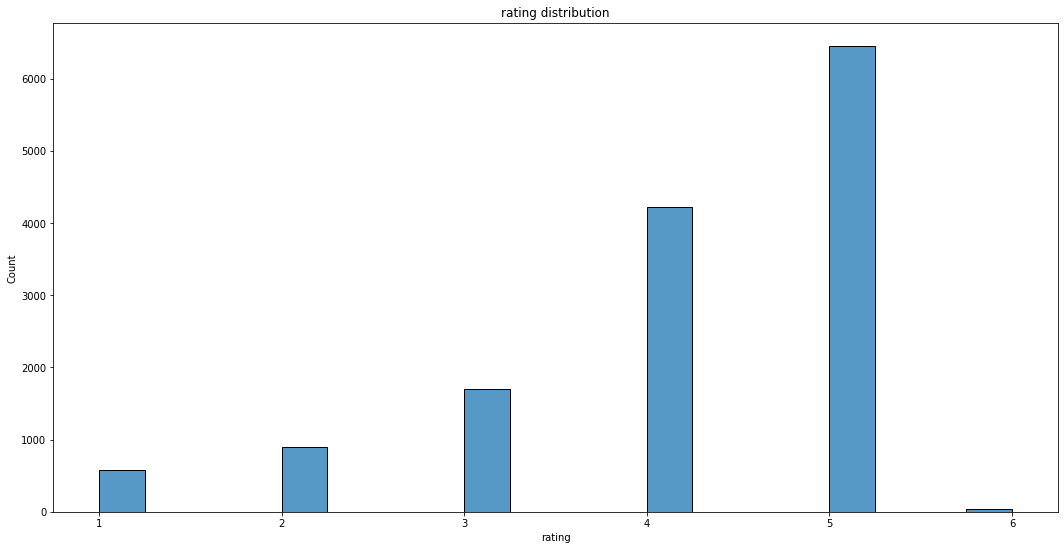

In [3]:
sns.histplot(data=dtrain, x='rating', bins=20)
plt.title('rating distribution')
plt.show()

## Important: training set and test set are of different time periods

In [4]:
dtrain['date'].unique(), dtest['date'].unique()

(array(['2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08',
        '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02',
        '2013-03', '2013-04', '2013-05', '2013-06'], dtype=object),
 array(['2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11',
        '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05',
        '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11',
        '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05',
        '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11',
        '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05',
        '2016-06', '2016-07', '2016-08', '2016-09', '2016-10'],
       dtype=object))

## Data preprocessing

We see there are not much overlaps between IDs in train and test sets

We may need features imputation later on

In [5]:
print("num of old user:", len(set(dtrain.userID.unique()).intersection(set(dtest.userID.unique()))))
print("num of quit user:", len(set(dtrain.userID.unique()).difference(set(dtest.userID.unique()))))
print("num of new user:", len(set(dtest.userID.unique()).difference(set(dtrain.userID.unique()))))
print("\n")
print("num of old item:", len(set(dtest.itemID.unique()).intersection(set(dtrain.itemID.unique()))))
print("num of quit item:", len(set(dtrain.itemID.unique()).difference(set(dtest.itemID.unique()))))
print("num of new item:", len(set(dtest.itemID.unique()).difference(set(dtrain.itemID.unique()))))

num of old user: 473
num of quit user: 2822
num of new user: 4531


num of old item: 1081
num of quit item: 420
num of new item: 1390


In [6]:
# Fitting the encoder
from sklearn.preprocessing import LabelEncoder

userID_enc = LabelEncoder()
userID_enc.fit(full_userIDs)

itemID_enc = LabelEncoder()
itemID_enc.fit(full_itemIDs)

genre_enc = LabelEncoder()
genre_enc.fit(full_genre)


dtrain_uid = userID_enc.transform(dtrain.userID)
dtest_uid = userID_enc.transform(dtest.userID)
# sanity check (see if the num transformed ID == num original ID)
num_uid = len(set(dtrain_uid).union(set(dtest_uid)))
print(num_uid, num_users)

dtrain_iid = itemID_enc.transform(dtrain.itemID)
dtest_iid = itemID_enc.transform(dtest.itemID)
# sanity check (see if the num transformed ID == num original ID)
num_iid = len(set(dtrain_iid).union(set(dtest_iid)))
print(num_iid, num_items)

dtrain_gid = genre_enc.transform(dtrain.genre)
dtest_gid = genre_enc.transform(dtest.genre)
# sanity check (see if the num transformed ID == num original ID)
num_gid = len(set(dtrain_gid).union(set(dtest_gid)))
print(num_gid, num_genre)

7826 7826
2891 2891
17 17


In [7]:
dtrain['userID_code'] = dtrain_uid
dtrain['itemID_code'] = dtrain_iid
dtrain['genre_code'] = dtrain_gid
dtest['userID_code'] = dtest_uid
dtest['itemID_code'] = dtest_iid
dtest['genre_code'] = dtest_gid

# Train-valid splitting by sorted dates

mimicing test set (records in the future)

In [8]:
valid_size = 0.2

dvalid = dtrain.sort_values('date').iloc[-int(len(dtrain)*valid_size):]
dvalid_with_rating = dvalid.copy()
valid_rating = dvalid['rating']
dvalid = dvalid.drop('rating', axis=1)
dtrain = dtrain.sort_values('date').iloc[:-int(len(dtrain)*valid_size)]

In [9]:
# Compute a global mean for later use
dfull = pd.concat([dtrain, dvalid_with_rating, dtest])
dfull_val = pd.concat([dtrain, dvalid, dtest])
glb_mean = dfull['rating'].mean()
glb_mean_val = dfull_val['rating'].mean()
print(glb_mean, glb_mean_val)
dfull.sample(3)

4.092668537304842 4.086960431654676


,userID,itemID,genre,rating,date,userID_code,itemID_code,genre_code
12081,3D2D6E,B06CDA,Zilin,NaN,2016-06,1843,1962,15
5218,5289F5,6813FD,Techno,NaN,2014-11,2489,1168,14
4729,7673B1,D20432,Zilin,NaN,2014-09,3573,2337,15


# Matrix Factorization (for users and items in train set)

 In the prediction phrase in test set, only records with both users and items existed in train set will be predicted

In [10]:
drated = dfull.dropna()

dmf = drated.copy()
user_mf, item_mf = dmf['userID_code'].unique(), dmf['itemID_code'].unique()
n_record = len(dmf)

## Use scikit-surprise package for SVDpp

In [11]:
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise import Dataset, NormalPredictor, Reader
from surprise.model_selection import cross_validate

In [12]:
algo = SVDpp()
reader = Reader(rating_scale=(1, 6))
data = Dataset.load_from_df(dmf[["userID_code", "itemID_code", "rating"]], reader)
trainset = data.build_full_trainset()
"5-fold mean valid rmse", np.mean(cross_validate(algo, data, cv=5)['test_rmse'])

('5-fold mean valid rmse', 0.9997227503035401)

In [13]:
algo.fit(trainset)

# predicts on train set
tmp = dmf.loc[(dmf.userID_code.isin(user_mf)) & (dmf.itemID_code.isin(item_mf)), ['userID_code', 'itemID_code']]
for u, i in zip(tmp['userID_code'], tmp['itemID_code']):
    dmf.loc[(dmf.userID_code == int(u)) & (dmf.itemID_code == int(i)), 'mf_pred_svdpp'] = algo.predict(int(u),int(i)).est
print("# predictions in train set", len(tmp))

# predicts on test set
tmp = dtest.loc[(dtest.userID_code.isin(user_mf)) & (dtest.itemID_code.isin(item_mf)), ['userID_code', 'itemID_code']]
for u, i in zip(tmp['userID_code'], tmp['itemID_code']):
    dtest.loc[(dtest.userID_code == int(u)) & (dtest.itemID_code == int(i)), 'mf_pred_svdpp'] = algo.predict(int(u),int(i)).est
print("# predictions in test set", len(tmp))

# predictions in train set 13899
# predictions in test set 1542


## MF predictions for old item / old user interaction in test set

Predict partial data only, it seems SVDpp predicts in a wider range

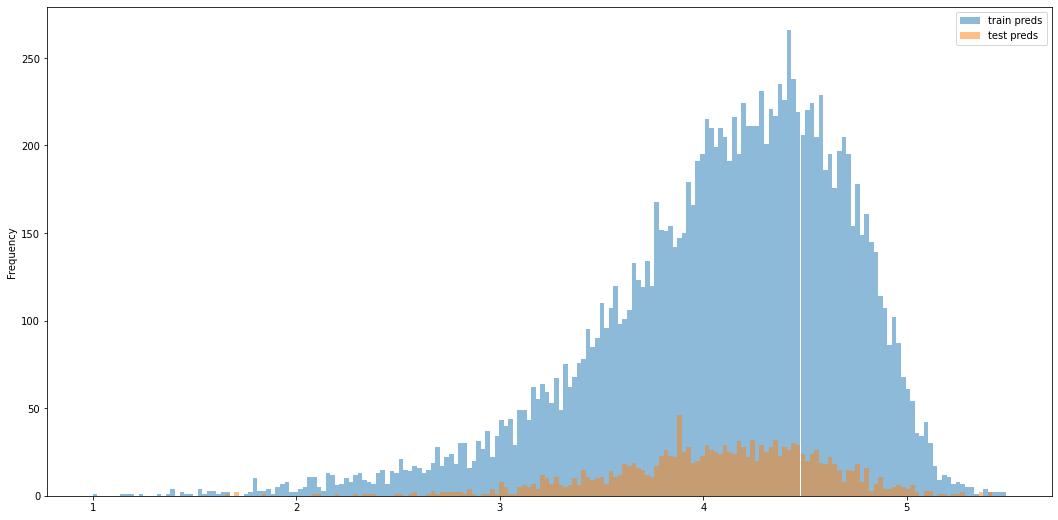

In [14]:
pd.concat({'train preds': dmf['mf_pred_svdpp'], 'test preds': dtest['mf_pred_svdpp']}, axis=1).plot.hist(bins=200, alpha=0.5)
plt.legend()
plt.show()

# Feature aggregation and engineering (side information)

Process user-related features (count, mean) and item-ralated features (count, mean, genre) from both train and test set.

nan is subsituted into mean when the ID is only found in test set

In [15]:
def gen_du(data):
    du = {'userID_code': [], 'count': [], 'mean': [], 'std': []}
    for u in range(num_users):
        if u % 500 == 0: print(f'generating user {u}')
        rating_tmp = data[data['userID_code'] == u]
        du['userID_code'].append(u)

        if len(rating_tmp)>0:
            # Append global count and mean of each user, regardless of genre
            du['count'].append(len(rating_tmp))
            du['mean'].append(rating_tmp['rating'].mean())
            du['std'].append(rating_tmp['rating'].std())
        else:
            print('found some uid with 0 records')
    return pd.DataFrame(du)
    

def gen_di(data):
    di = {'itemID_code': [], 'count': [], 'mean': [], 'std':[], 'genre': [], 'genre_code': []}
    for i in range(num_items):
        if i % 500 == 0: print(f'generating item {i}')
        rating_tmp = data[data['itemID_code'] == i]
        di['itemID_code'].append(i)

        if len(rating_tmp)>0:
            # Append count and mean and genre of each item
            di['count'].append(len(rating_tmp))
            di['mean'].append((rating_tmp['rating']).mean())
            di['std'].append((rating_tmp['rating']).std())
            di['genre'].append(rating_tmp['genre'].iloc[0])
            di['genre_code'].append(rating_tmp['genre_code'].iloc[0])
        else:
            print('found some iid with 0 records')

    return pd.DataFrame(di)

du = gen_du(dfull)
di = gen_di(dfull)
du_val = gen_du(dfull_val)
di_val = gen_di(dfull_val)
len(du), len(di), len(du_val), len(di_val)

generating user 0
generating user 500
generating user 1000
generating user 1500
generating user 2000
generating user 2500
generating user 3000
generating user 3500
generating user 4000
generating user 4500
generating user 5000
generating user 5500
generating user 6000
generating user 6500
generating user 7000
generating user 7500
generating item 0
generating item 500
generating item 1000
generating item 1500
generating item 2000
generating item 2500
generating user 0
generating user 500
generating user 1000
generating user 1500
generating user 2000
generating user 2500
generating user 3000
generating user 3500
generating user 4000
generating user 4500
generating user 5000
generating user 5500
generating user 6000
generating user 6500
generating user 7000
generating user 7500
generating item 0
generating item 500
generating item 1000
generating item 1500
generating item 2000
generating item 2500


(7826, 2891, 7826, 2891)

## Create following list and follower list

In [16]:
net = pd.read_csv('/kaggle/input/cuhkstat3009-p2/user_social_net.csv')
net['from'] = userID_enc.transform(net['from'])
net['to'] = userID_enc.transform(net['to'])

following, followers = {}, {}
for row in net.iterrows():
    a = row[1]['from']
    b = row[1]['to']
#     print(a, b)
    if following.get(a) is None:
        following[a] = [b]
    else:
        following[a].append(b)
        
    if followers.get(b) is None:
        followers[b] = [a]
    else:
        followers[b].append(a)

# Num users who follows other and num users who have followers
len(following), len(followers)

(207, 775)

Add num following, num followers and mutual followers as user-related features

In [17]:
n_following, n_followers, n_mutual, n_connect = [], [], [], []
u_following, u_followers, u_mutual, u_connect = [], [], [], []
for u in range(num_users):
    user_following = following.get(u, [])
    user_followers = followers.get(u, [])
    u_following.append(user_following)
    u_followers.append(user_followers)
    n_following.append(len(user_following))
    n_followers.append(len(user_followers))
    
    mutual_follow = list(set(user_following).intersection(user_followers))
    u_mutual.append(mutual_follow)
    n_mutual.append(len(mutual_follow))
    
    connect = list(set(user_following).union(user_followers))
    u_connect.append(connect)
    n_connect.append(len(connect))

du['n_following'] = n_following
du['n_followers'] = n_followers
du['n_mutual'] = n_mutual
du['n_connect'] = n_connect

du_val['n_following'] = n_following
du_val['n_followers'] = n_followers
du_val['n_mutual'] = n_mutual
du_val['n_connect'] = n_connect

du['u_following'] = u_following
du['u_followers'] = u_followers
du['u_mutual'] = u_mutual
du['u_connect'] = u_connect

du_val['u_following'] = u_following
du_val['u_followers'] = u_followers
du_val['u_mutual'] = u_mutual
du_val['u_connect'] = u_connect
(du['n_connect'] > 0).sum(), (du_val['n_connect'] > 0).sum()

(849, 849)

In [18]:
# visual sanity check, mutual should not exceeds min(following, followers)
#connect = following +followers-mutual
du.loc[du['n_connect'] > 0, :].sample(3)

,userID_code,count,mean,std,n_following,n_followers,n_mutual,n_connect,u_following,u_followers,u_mutual,u_connect
2001,2001,10,NaN,NaN,0,1,0,1,[],[3029],[],[3029]
3235,3235,9,4.333333,1.000000,0,1,0,1,[],[5098],[],[5098]
620,620,6,1.333333,0.516398,0,1,0,1,[],[4102],[],[4102]


Build adj matrixs for user connections and user mutual followers

In [19]:
adj_mat = np.zeros((num_users, num_users))
for uid in range(num_users):
    for u_con in du.loc[du['userID_code'] == uid, 'u_connect'].iloc[0]:
        adj_mat[uid][u_con] = 1

np.sum(~(adj_mat.T == adj_mat)) # check if adj_mat is symmetric

0

# Compute neighbor predictions mean by SVDpp
**REMARK: Won't give predictions if neighbor users or the item is outside the model**

In [20]:
for (uid, iid) in zip(dtest['userID_code'], dtest['itemID_code']):
#     print(uid, iid)
    preds, rates = [], []
    following = du.loc[du['userID_code'] == uid, 'u_following'].iloc[0]
    if len(following) > 0:
        for uf in following:
#             print(uf in user_mf, iid in item_mf)
            if (uf in user_mf) and (iid in item_mf):
                pred_tmp = algo.predict(uf, iid)
                rate_tmp = drated.loc[(drated['userID_code'] == uf) & (drated['itemID_code'] == iid), 'rating']
                if len(rate_tmp) > 0:
                    rates.append(rate_tmp.iloc[0])
                preds.append(pred_tmp.est)
    if len(preds) > 0:
        dtest.loc[(dtest['userID_code'] == uid) & (dtest['itemID_code'] == iid), 'mf_pred_nbr'] = np.mean(preds)
    else:
        dtest.loc[(dtest['userID_code'] == uid) & (dtest['itemID_code'] == iid), 'mf_pred_nbr'] = np.nan
        
    if len(rates) > 0:
        dtest.loc[(dtest['userID_code'] == uid) & (dtest['itemID_code'] == iid), 'rate_nbr'] = np.mean(rates)
    else:
        dtest.loc[(dtest['userID_code'] == uid) & (dtest['itemID_code'] == iid), 'rate_nbr'] = np.nan

In [21]:
(~dtest['mf_pred_nbr'].isna()).sum(), (~dtest['rate_nbr'].isna()).sum()

(449, 46)

## Two strategies for final SVDpp predictions
1. Use pure self svdpp predictions, then fillna by neighbor svdpp predictions
2. Use mean of self svdpp predictions and neighbour svdpp predictions

IMO, 1 make more sense because self effect should be dominant, neighbour effect is supplement

In [22]:
dtest['rate_pred_nbr_mean'] = dtest[['rate_nbr', 'mf_pred_nbr']].mean(axis=1)

dtest['mf_pred_svdpp_fillna_pred_nbr'] = dtest['mf_pred_svdpp'].fillna(dtest['mf_pred_nbr'])
dtest['mf_pred_svdpp_fillna_nbr'] = dtest['mf_pred_svdpp'].fillna(dtest['rate_nbr']).fillna(dtest['mf_pred_nbr'])
dtest['mf_pred_svdpp_fillna_mean_nbr'] = dtest['mf_pred_svdpp'].fillna(dtest['rate_pred_nbr_mean'])

dtest['mf_pred_svdpp_nbr_mean'] = dtest[['mf_pred_svdpp', 'rate_pred_nbr_mean']].mean(axis=1)

In [23]:
dtest[['mf_pred_svdpp', 'mf_pred_nbr', 'rate_nbr', 'mf_pred_svdpp_fillna_nbr', 'mf_pred_svdpp_nbr_mean']].sample(20)

,mf_pred_svdpp,mf_pred_nbr,rate_nbr,mf_pred_svdpp_fillna_nbr,mf_pred_svdpp_nbr_mean
10739,NaN,NaN,NaN,NaN,NaN
7799,NaN,NaN,NaN,NaN,NaN
5518,NaN,NaN,NaN,NaN,NaN
6551,NaN,NaN,NaN,NaN,NaN
4100,NaN,NaN,NaN,NaN,NaN
189,NaN,NaN,NaN,NaN,NaN
13479,NaN,NaN,NaN,NaN,NaN
1677,NaN,NaN,NaN,NaN,NaN
11686,NaN,NaN,NaN,NaN,NaN
2708,NaN,NaN,NaN,NaN,NaN


# Extra feature engineering
## Social networks and features transformation

In [24]:
# Connected users mean or following users mean in the social network
def socnet_mean(du):
    du_in_net = du.loc[du['n_following'] > 0, ['userID_code', 'u_following']]
    for (uid, ucon) in zip(du_in_net['userID_code'], du_in_net['u_following']):
        ucon_mean = du.loc[du['userID_code'].isin(ucon), 'mean'].mean()
        du.loc[du['userID_code'] == uid, 'mean_following'] = ucon_mean
        
    du_in_net = du.loc[du['n_connect'] > 0, ['userID_code', 'u_connect']]
    for (uid, ucon) in zip(du_in_net['userID_code'], du_in_net['u_connect']):
        ucon_mean = du.loc[du['userID_code'].isin(ucon), 'mean'].mean()
        du.loc[du['userID_code'] == uid, 'mean_connect'] = ucon_mean

    return du

In [25]:
du = socnet_mean(du)
du_val = socnet_mean(du_val)

In [26]:
du['log_count'] = np.log(du['count'])
du['log_n_following'] = np.log(du['n_following'] + 1)
du['log_n_connect'] = np.log(du['n_connect'] + 1)

du['sqrt_count'] = np.sqrt(du['count'])
du['sqrt_n_following'] = np.sqrt(du['n_following'])
du['sqrt_n_connect'] = np.sqrt(du['n_connect'])

du_val['log_count'] = np.log(du_val['count'])
du_val['log_n_following'] = np.log(du_val['n_following'] + 1)
du_val['log_n_connect'] = np.log(du_val['n_connect'] + 1)

du_val['sqrt_count'] = np.sqrt(du_val['count'])
du_val['sqrt_n_following'] = np.sqrt(du_val['n_following'])
du_val['sqrt_n_connect'] = np.sqrt(du_val['n_connect'])

# EDA

## On user features, mainly about correlation checking and linear regression with user mean

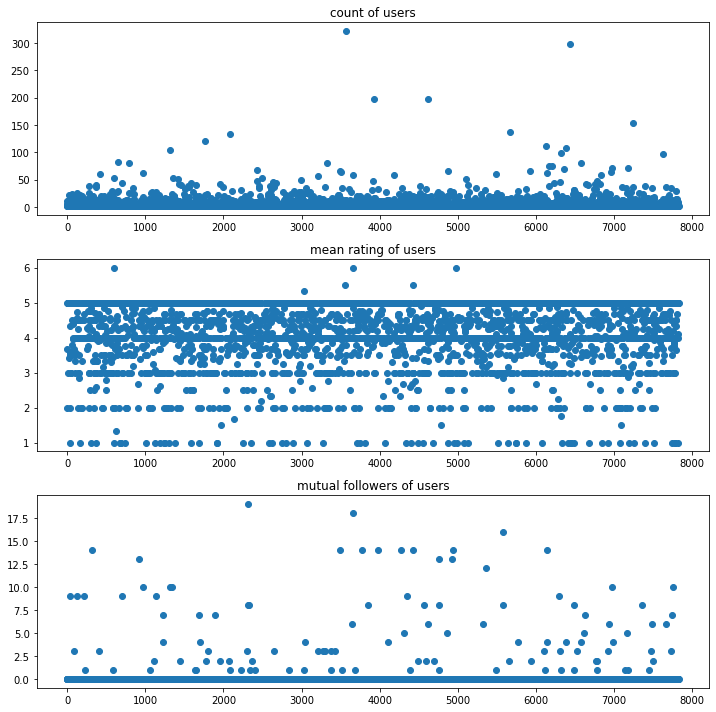

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
# tmp = du.head(50)
du['count'].plot(ls='', marker='o', ax=axs[0])
axs[0].set_title('count of users')
du['mean'].plot(ls='', marker='o', ax=axs[1])
axs[1].set_title('mean rating of users')
du['n_mutual'].plot(ls='', marker='o', ax=axs[2])
axs[2].set_title('mutual followers of users')
plt.tight_layout()

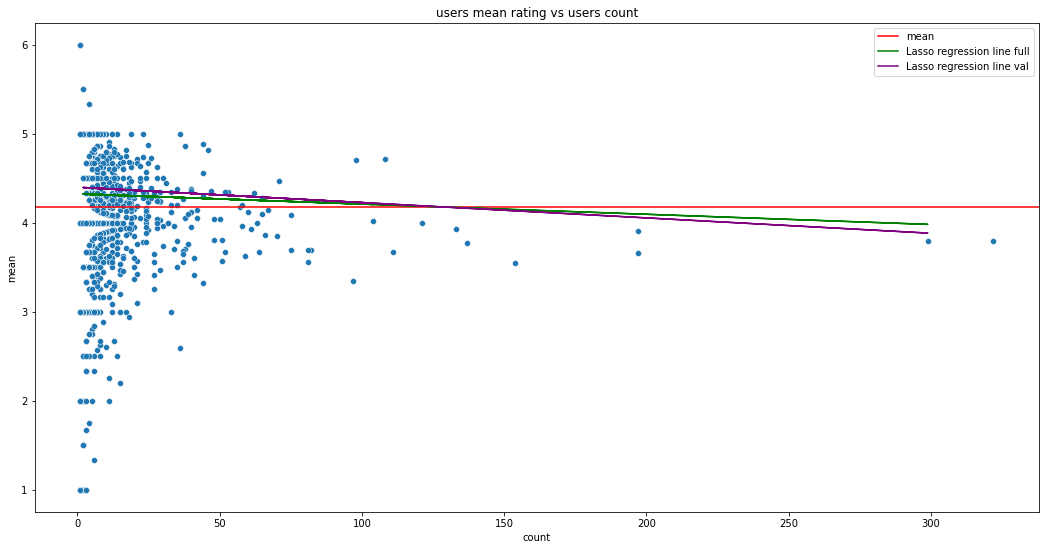

In [28]:
from sklearn.linear_model import Lasso

y_full, X_full = du.dropna()['mean'].values, du.dropna()['count'].values
user_reg_full = Lasso(alpha=0.1)
user_reg_full.fit(X_full.reshape(-1, 1), y_full)

y_val, X_val = du_val.dropna()['mean'].values, du_val.dropna()['count'].values
user_reg_val = Lasso(alpha=0.1)
user_reg_val.fit(X_val.reshape(-1, 1), y_val)

sns.scatterplot(data=du, x='count', y='mean')
plt.axhline(du['mean'].mean(), c='r', label='mean')
plt.plot(X_full, X_full * user_reg_full.coef_[0] + user_reg_full.intercept_, c='g', label='Lasso regression line full')
plt.plot(X_val, X_val * user_reg_val.coef_[0] + user_reg_val.intercept_, c='purple', label='Lasso regression line val')
plt.title('users mean rating vs users count')
plt.legend()

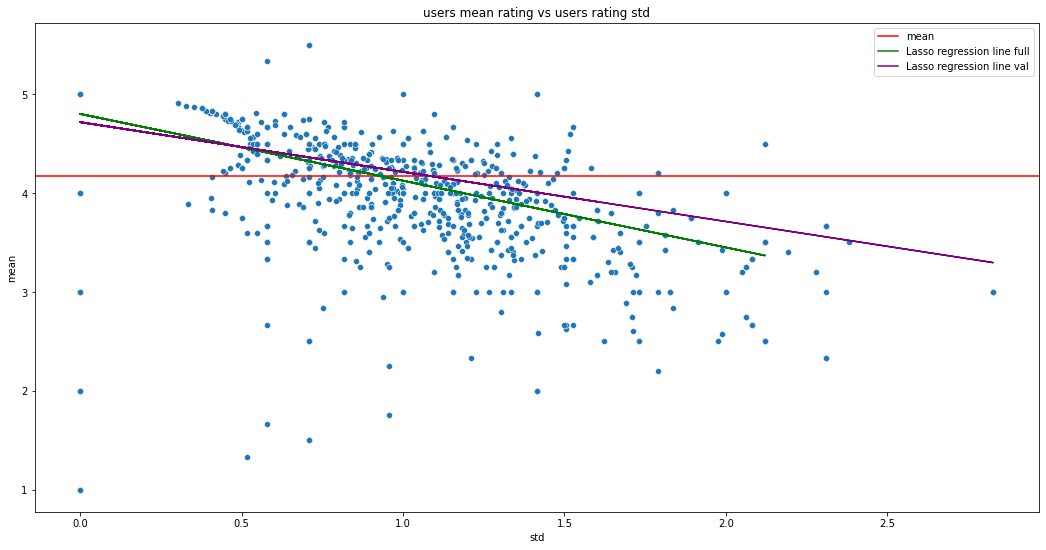

In [29]:
y_full, X_full = du.dropna()['mean'].values, du.dropna()['std'].values
user_reg_full = Lasso(alpha=0.1)
user_reg_full.fit(X_full.reshape(-1, 1), y_full)

y_val, X_val = du_val.dropna()['mean'].values, du_val.dropna()['std'].values
user_reg_val = Lasso(alpha=0.1)
user_reg_val.fit(X_val.reshape(-1, 1), y_val)

sns.scatterplot(data=du, x='std', y='mean')
plt.axhline(du['mean'].mean(), c='r', label='mean')
plt.plot(X_full, X_full * user_reg_full.coef_[0] + user_reg_full.intercept_, c='g', label='Lasso regression line full')
plt.plot(X_val, X_val * user_reg_val.coef_[0] + user_reg_val.intercept_, c='purple', label='Lasso regression line val')
plt.title('users mean rating vs users rating std')
plt.legend()

Validation du

In [30]:
all_user_feature = ['n_mutual', 'n_followers', 'n_following', 'log_n_following', 'sqrt_n_following', 'n_connect', 'log_n_connect', 'sqrt_n_connect', 'count', 'log_count', 'sqrt_count', 'std', 
                    'mean_following', 'mean_connect','mean']
du_val[all_user_feature].corr()

,n_mutual,n_followers,n_following,log_n_following,sqrt_n_following,n_connect,log_n_connect,sqrt_n_connect,count,log_count,sqrt_count,std,mean_following,mean_connect,mean
n_mutual,1.000000,0.740902,0.746170,0.703864,0.726417,0.791685,0.568129,0.643596,0.108943,0.117548,0.131147,0.012673,0.148452,-0.022784,0.009981
n_followers,0.740902,1.000000,0.523528,0.513380,0.523428,0.817118,0.741462,0.780205,0.202457,0.200477,0.230616,0.006006,0.168841,0.009258,0.005575
n_following,0.746170,0.523528,1.000000,0.927793,0.962074,0.911472,0.712881,0.784553,0.105896,0.132556,0.135374,-0.030560,0.054003,-0.129197,0.028819
log_n_following,0.703864,0.513380,0.927793,1.000000,0.994210,0.858946,0.771178,0.813261,0.123399,0.142390,0.148370,-0.036831,0.004495,-0.178485,0.029062
sqrt_n_following,0.726417,0.523428,0.962074,0.994210,1.000000,0.886343,0.765762,0.817056,0.119842,0.141676,0.146666,-0.035415,0.028308,-0.166339,0.029594
n_connect,0.791685,0.817118,0.911472,0.858946,0.886343,1.000000,0.849278,0.911084,0.173211,0.190736,0.207174,-0.020622,0.117448,-0.096832,0.022439
log_n_connect,0.568129,0.741462,0.712881,0.771178,0.765762,0.849278,1.000000,0.990277,0.215876,0.258972,0.269949,-0.022842,0.079544,-0.159985,0.019838
sqrt_n_connect,0.643596,0.780205,0.784553,0.813261,0.817056,0.911084,0.990277,1.000000,0.210455,0.251110,0.262634,-0.023150,0.102505,-0.135171,0.021409
count,0.108943,0.202457,0.105896,0.123399,0.119842,0.173211,0.215876,0.210455,1.000000,0.653997,0.874665,0.089550,0.078036,0.010597,-0.038538
log_count,0.117548,0.200477,0.132556,0.142390,0.141676,0.190736,0.258972,0.251110,0.653997,1.000000,0.926455,0.166889,0.067542,0.025112,-0.035884


In [31]:
reg_feature = ['n_mutual', 'n_followers', 'n_following', 'n_connect', 'count', 'std']
tmp_val = du_val[reg_feature+['mean']].dropna()
y_val, X_val = tmp_val['mean'].values, tmp_val[reg_feature].values
reg_tmp = Lasso(alpha=0.01)
reg_tmp.fit(X_val, y_val)
reg_tmp.coef_

array([-0.00000000e+00, -0.00000000e+00,  3.91963472e-03,  0.00000000e+00,
       -5.40646844e-04, -6.30640269e-01])

Full data du

In [32]:
du[all_user_feature].corr()

,n_mutual,n_followers,n_following,log_n_following,sqrt_n_following,n_connect,log_n_connect,sqrt_n_connect,count,log_count,sqrt_count,std,mean_following,mean_connect,mean
n_mutual,1.000000,0.740902,0.746170,0.703864,0.726417,0.791685,0.568129,0.643596,0.108943,0.117548,0.131147,0.015604,0.157859,-0.005816,0.004652
n_followers,0.740902,1.000000,0.523528,0.513380,0.523428,0.817118,0.741462,0.780205,0.202457,0.200477,0.230616,0.028911,0.186803,0.010801,0.002213
n_following,0.746170,0.523528,1.000000,0.927793,0.962074,0.911472,0.712881,0.784553,0.105896,0.132556,0.135374,-0.015603,0.054369,-0.093969,0.022523
log_n_following,0.703864,0.513380,0.927793,1.000000,0.994210,0.858946,0.771178,0.813261,0.123399,0.142390,0.148370,-0.019991,0.025317,-0.138297,0.027071
sqrt_n_following,0.726417,0.523428,0.962074,0.994210,1.000000,0.886343,0.765762,0.817056,0.119842,0.141676,0.146666,-0.019174,0.038923,-0.127300,0.026117
n_connect,0.791685,0.817118,0.911472,0.858946,0.886343,1.000000,0.849278,0.911084,0.173211,0.190736,0.207174,0.002895,0.126529,-0.070296,0.016976
log_n_connect,0.568129,0.741462,0.712881,0.771178,0.765762,0.849278,1.000000,0.990277,0.215876,0.258972,0.269949,0.010064,0.105725,-0.136433,0.025315
sqrt_n_connect,0.643596,0.780205,0.784553,0.813261,0.817056,0.911084,0.990277,1.000000,0.210455,0.251110,0.262634,0.008051,0.120164,-0.109760,0.024350
count,0.108943,0.202457,0.105896,0.123399,0.119842,0.173211,0.215876,0.210455,1.000000,0.653997,0.874665,0.091644,0.060861,-0.005036,-0.039869
log_count,0.117548,0.200477,0.132556,0.142390,0.141676,0.190736,0.258972,0.251110,0.653997,1.000000,0.926455,0.164900,0.063706,0.013530,-0.046789


In [33]:
tmp_full = du[reg_feature+['mean']].dropna()
y_full, X_full = tmp_full['mean'].values, tmp_full[reg_feature].values
reg_tmp = Lasso(alpha=0.01)
reg_tmp.fit(X_full, y_full)
reg_tmp.coef_

array([ 0.00000000e+00,  0.00000000e+00,  2.25944914e-03,  3.17369195e-04,
       -3.32813933e-04, -6.55537977e-01])

<!-- Correlation suggest use **n_following and count** in both validation data and full data for mlr?

Lasso suggest use **n_connect**, **n_following**, **count** in validation data for mlr?

Lasso suggest use **n_connect**, **count** in full data for mlr? -->

Lasso suggest use n_following, **n_connect, count** as features only

Correlation matrix shows transformed n_following, n_connect, count has highest corr (still tiny)

In [34]:
y_full, X_full = du_val.dropna()['mean'].values, du_val.dropna()[['sqrt_n_following', 'log_n_following', 'n_following']].values
reg_tmp = Lasso(alpha=0.05)
reg_tmp.fit(X_full, y_full)
print('transformation choice (n_following)', reg_tmp.coef_)

y_full, X_full = du_val.dropna()['mean'].values, du_val.dropna()[['sqrt_n_connect', 'log_n_connect', 'n_connect']].values
reg_tmp = Lasso(alpha=0.05)
reg_tmp.fit(X_full, y_full)
print('transformation choice (n_connect)', reg_tmp.coef_)

y_full, X_full = du_val.dropna()['mean'].values, du_val.dropna()[['sqrt_count', 'log_count', 'count']].values
reg_tmp = Lasso(alpha=0.05)
reg_tmp.fit(X_full, y_full)
print('transformation choice (count)', reg_tmp.coef_)

transformation choice (n_following) [0.         0.         0.00201896]
transformation choice (n_connect) [ 0.14528213  0.         -0.01678112]
transformation choice (count) [-0.00000000e+00 -9.31903491e-02 -2.40170195e-05]


In [35]:
y_full, X_full = du.dropna()['mean'].values, du.dropna()[['sqrt_n_following', 'log_n_following', 'n_following']].values
reg_tmp = Lasso(alpha=0.05)
reg_tmp.fit(X_full, y_full)
print('transformation choice (n_following)', reg_tmp.coef_)

y_full, X_full = du.dropna()['mean'].values, du.dropna()[['sqrt_n_connect', 'log_n_connect', 'n_connect']].values
reg_tmp = Lasso(alpha=0.05)
reg_tmp.fit(X_full, y_full)
print('transformation choice (n_connect)', reg_tmp.coef_)

y_full, X_full = du.dropna()['mean'].values, du.dropna()[['sqrt_count', 'log_count', 'count']].values
reg_tmp = Lasso(alpha=0.05)
reg_tmp.fit(X_full, y_full)
print('transformation choice (count)', reg_tmp.coef_)

transformation choice (n_following) [0. 0. 0.]
transformation choice (n_connect) [ 0.01039761  0.         -0.00410297]
transformation choice (count) [ 0.         -0.         -0.00116696]


## No transformation is better as suggested by lasso

also, multicollinearity between n_following and n_connect?

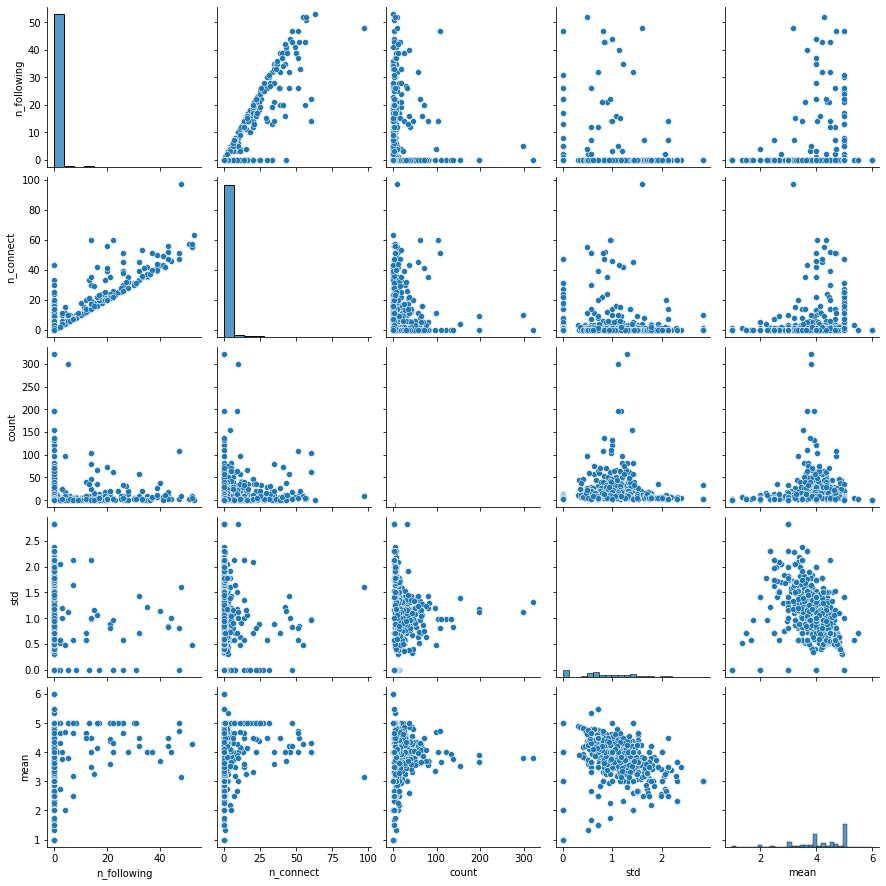

In [36]:
sns.pairplot(data=du[['n_following', 'n_connect', 'count', 'std', 'mean']])
fig.tight_layout()

## On item features, mainly about correlation checking and linear regression on item mean

Text(0.5, 1.0, 'item mean rating')

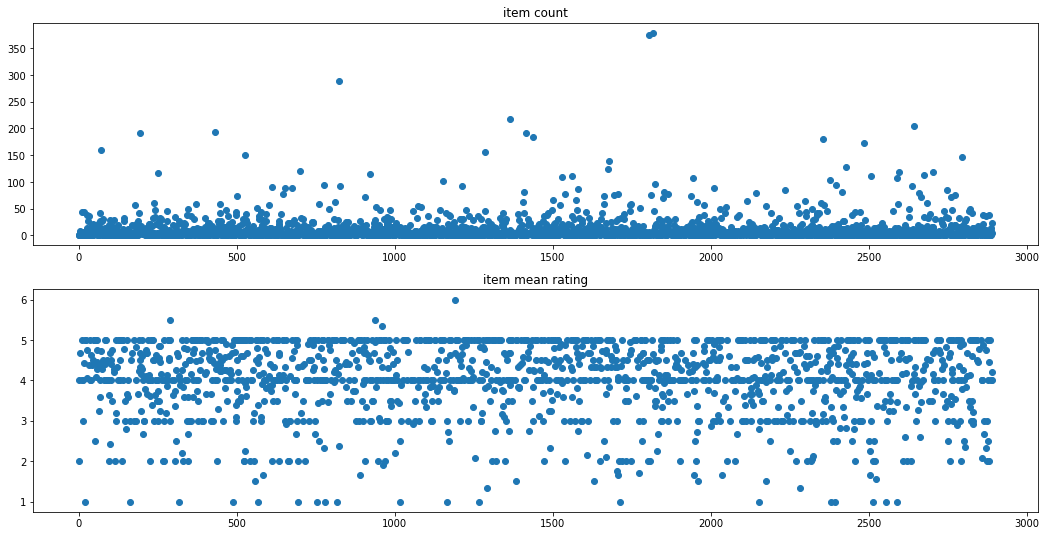

In [37]:
fig, axs = plt.subplots(2, 1)
di['count'].plot(ls='', marker='o', ax=axs[0])
axs[0].set_title('item count')
di['mean'].plot(ls='', marker='o', ax=axs[1])
axs[1].set_title('item mean rating')

In [42]:
di[['count', 'std', 'mean']].corr()

,count,std,mean
count,1.000000,0.088084,0.058731
std,0.088084,1.000000,-0.515075
mean,0.058731,-0.515075,1.000000


Text(0.5, 1.0, 'item mean rating vs item count')

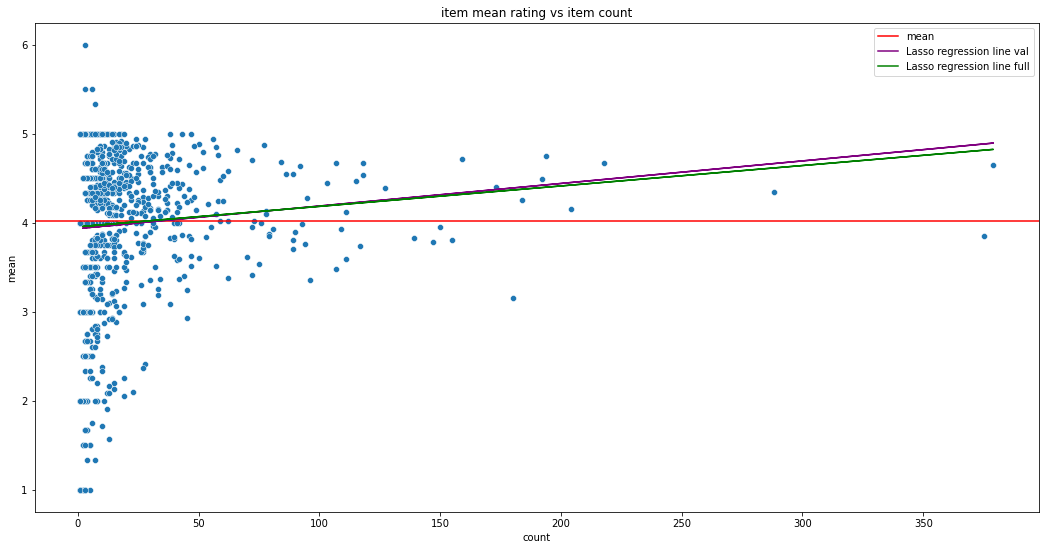

In [38]:
y_full, X_full = di.dropna()['mean'].values, di.dropna()['count'].values
item_reg_full = Lasso(alpha=0.1)
item_reg_full.fit(X_full.reshape(-1, 1), y_full)

y_val, X_val = di_val.dropna()['mean'].values, di_val.dropna()['count'].values
item_reg_val = Lasso(alpha=0.1)
item_reg_val.fit(X_val.reshape(-1, 1), y_val)

sns.scatterplot(data=di, x='count', y='mean')
plt.axhline(di['mean'].mean(), c='r', label='mean')
plt.plot(X_val, X_val * item_reg_val.coef_[0] + item_reg_val.intercept_, c='purple', label='Lasso regression line val')
plt.plot(X_full, X_full * item_reg_full.coef_[0] + item_reg_full.intercept_, c='g', label='Lasso regression line full')
plt.legend()
plt.title('item mean rating vs item count')

Text(0.5, 1.0, 'item mean rating vs item std')

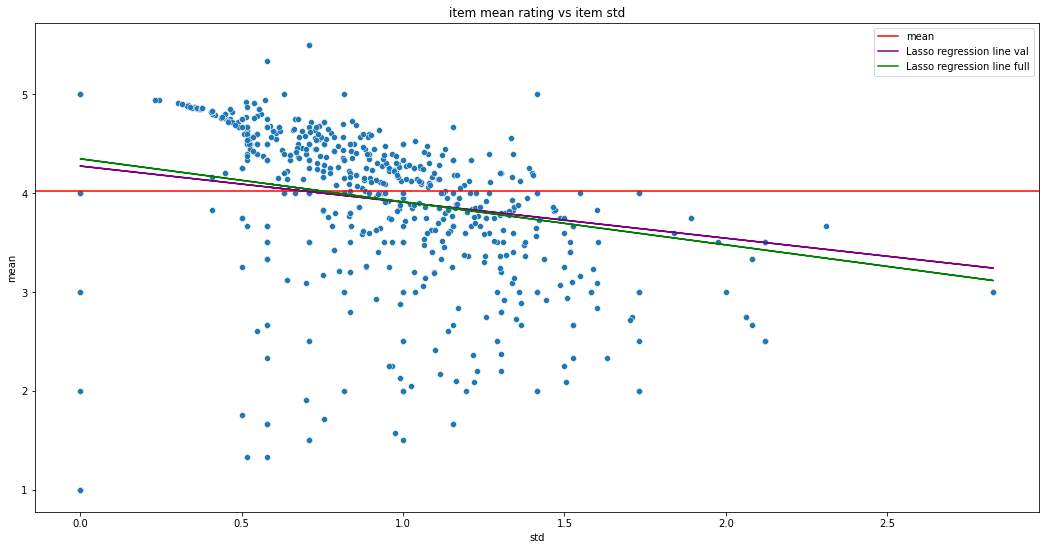

In [39]:
y_full, X_full = di.dropna()['mean'].values, di.dropna()['std'].values
item_reg_full = Lasso(alpha=0.1)
item_reg_full.fit(X_full.reshape(-1, 1), y_full)

y_val, X_val = di_val.dropna()['mean'].values, di_val.dropna()['std'].values
item_reg_val = Lasso(alpha=0.1)
item_reg_val.fit(X_val.reshape(-1, 1), y_val)

sns.scatterplot(data=di, x='std', y='mean')
plt.axhline(di['mean'].mean(), c='r', label='mean')
plt.plot(X_val, X_val * item_reg_val.coef_[0] + item_reg_val.intercept_, c='purple', label='Lasso regression line val')
plt.plot(X_full, X_full * item_reg_full.coef_[0] + item_reg_full.intercept_, c='g', label='Lasso regression line full')
plt.legend()
plt.title('item mean rating vs item std')

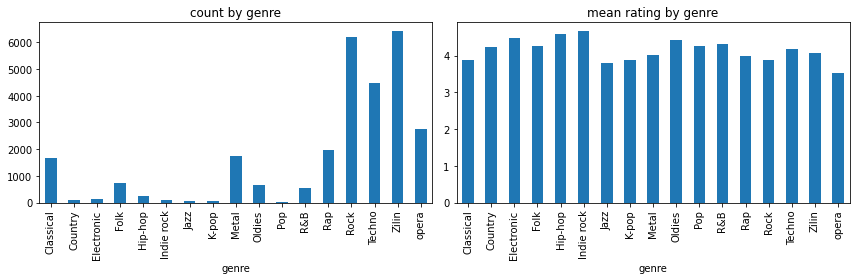

In [40]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
di.groupby('genre').sum()['count'].plot.bar(title='count by genre', ax=axes[0])
di.groupby('genre').mean()['mean'].plot.bar(title='mean rating by genre', ax=axes[1])
fig.tight_layout()

# Baseline methods and Regression methods
Playing around with global mean, user mean, item mean, genre mean predictions

Regression of user / item mean by selected features from EDA

- Note 1: genre mean serves as alternative of global mean, we must have all predictions
- Note 2: Multiple linear regression is more preferred than many single LR models, such that the joint effects of features are included

In [96]:
genre_mean_val = di_val.groupby('genre').mean()[['genre_code', 'mean']]
genre_mean = di.groupby('genre').mean()[['genre_code', 'mean']]

In [97]:
def genre_mean_func(data, genre_mean):
    pred = data.merge(genre_mean, how='left', on='genre_code', suffixes=('', '_genre'))
    return pred

def genre_reg(data, di, alpha=0.05):
    di_tmp = di.copy()
    for gcode in range(num_genre):
        di_genre = di_tmp.loc[di['genre_code'] == gcode]
        gen_reg = di_genre[['count', 'mean']].dropna()
        X, y = gen_reg[['count']].values, gen_reg['mean'].values
        reg = Lasso(alpha=alpha)
        reg.fit(X.reshape(-1, 1), y)
        di_tmp.loc[di['genre_code'] == gcode, 'reg_genre'] = di_genre[['count']].values.dot(reg.coef_) + reg.intercept_
    pred = data.merge(di_tmp[['itemID_code', 'reg_genre']], how='left', on='itemID_code', suffixes=('', '_item'))
    return pred
        
def user_mean(data, du):
    pred = data.merge(du[['userID_code', 'mean', 'count']], how='left', on='userID_code', suffixes=('', '_user'))
    return pred

def user_reg(data, du, target=['mean'], regressors=['count', 'n_following'], alpha=0.05):
    du_tmp = du.copy()
    du_reg = du_tmp[target+regressors].dropna()
    y_val, X_val = du_reg[target].values, du_reg[regressors].values
    reg = Lasso(alpha=alpha)
    reg.fit(X_val, y_val)
    du_tmp['reg_user'] = du_tmp[regressors].values.dot(reg.coef_) + reg.intercept_
    
    pred = data.merge(du_tmp[['userID_code','reg_user']], how='left', on='userID_code', suffixes=('', '_user'))
    return pred

def item_mean(data, di):
    pred = data.merge(di[['itemID_code', 'mean', 'count']], how='left', on='itemID_code', suffixes=('', '_item'))
    return pred

def item_reg(data, di, target=['mean'], regressors=['count'], alpha=0.05):
    di_tmp = di.copy()
    di_reg = di_tmp[target+regressors].dropna()
    y_val, X_val = di_reg[target].values, di_reg[regressors].values
    reg = Lasso(alpha=alpha)
    reg.fit(X_val, y_val)
    di['reg_item'] =  di[regressors].values.dot(reg.coef_) + reg.intercept_
    
    pred = data.merge(di[['itemID_code', 'reg_item']], how='left', on='itemID_code', suffixes=('', '_item'))
    return pred

In [98]:
# Models for train set in the train-valid split
tra_imean = item_mean(dtrain, di_val)['mean']
tra_ireg = item_reg(dtrain, di_val)['reg_item']

tra_gmean = genre_mean_func(dtrain, genre_mean_val)['mean']
tra_greg = genre_reg(dtrain, di_val)['reg_genre']

tra_umean = user_mean(dtrain, du_val)['mean']
tra_ureg1 = user_reg(dtrain, du_val, regressors=['count'])['reg_user'] # count, alpha=0.05
tra_ureg2 = user_reg(dtrain, du_val)['reg_user'] # count, n_following, alpha=0.05
tra_ureg3 = user_reg(dtrain, du_val, regressors=['count', 'n_connect'])['reg_user'] # count, n_connect, alpha=0.05
tra_ureg4 = user_reg(dtrain, du_val, regressors=['mean_following'], alpha=0.01)['reg_user']
tra_ureg5 = user_reg(dtrain, du_val, regressors=['count', 'n_following', 'mean_following'], alpha=0.05)['reg_user']
tra_ureg6 = user_reg(dtrain, du_val, regressors=['std'])['reg_user']
tra_ureg2_sqrt = user_reg(dtrain, du_val, regressors=['sqrt_count', 'sqrt_n_following'])['reg_user']

tra_ig_mean = pd.concat([tra_imean, tra_gmean], axis=1).mean(axis=1)
tra_iug_mean = pd.concat([tra_imean, tra_gmean, tra_umean], axis=1).mean(axis=1)
tra_ig_mean_reg1 = pd.concat([tra_imean, tra_gmean, tra_ureg1], axis=1).mean(axis=1)
tra_ig_mean_reg2 = pd.concat([tra_imean, tra_gmean, tra_ureg2], axis=1).mean(axis=1)
tra_i_mean_reg2 = pd.concat([tra_imean, tra_ureg2], axis=1).mean(axis=1)

print('item, genre mean: ', RMSE(tra_ig_mean.values, dtrain['rating'].values))
print('item, user, genre mean: ', RMSE(tra_iug_mean.values, dtrain['rating'].values))
print('item, genre mean ; user cnt reg avg:', RMSE(tra_ig_mean_reg1.values, dtrain['rating'].values))
print('item, genre mean ; user cnt, n_following reg avg:', RMSE(tra_ig_mean_reg2.values, dtrain['rating'].values))
print('item mean ; user cnt, n_following reg avg:', RMSE(tra_i_mean_reg2.values, dtrain['rating'].values))

item, genre mean:  0.9713112906215156
item, user, genre mean:  0.9057410922539704
item, genre mean ; user cnt reg avg: 1.004479608706353
item, genre mean ; user cnt, n_following reg avg: 1.0039746115757884
item mean ; user cnt, n_following reg avg: 0.969640627981375


In [99]:
# Models for the valid set in the train-valid split
val_imean = item_mean(dvalid, di_val)['mean']
val_ireg = item_reg(dvalid, di_val)['reg_item']
val_ireg2 = item_reg(dvalid, di_val, regressors=['std'])['reg_item']

val_gmean = genre_mean_func(dvalid, genre_mean_val)['mean']
val_greg = genre_reg(dvalid, di_val)['reg_genre']

val_umean = user_mean(dvalid, du_val)['mean']
val_ureg1 = user_reg(dvalid, du_val, regressors=['count'])['reg_user'] # count, alpha=0.05
val_ureg2 = user_reg(dvalid, du_val)['reg_user'] # count, n_following, alpha=0.05
val_ureg3 = user_reg(dvalid, du_val, regressors=['count', 'n_connect'])['reg_user'] # count, n_connect, alpha=0.05
val_ureg4 = user_reg(dvalid, du_val, regressors=['mean_following'], alpha=0.05)['reg_user']
val_ureg5 = user_reg(dvalid, du_val, regressors=['count', 'n_following', 'mean_following'], alpha=0.05)['reg_user']
val_ureg6 = user_reg(dvalid, du_val, regressors=['std'])['reg_user']
val_ureg2_sqrt = user_reg(dvalid, du_val, regressors=['sqrt_count', 'sqrt_n_following'])['reg_user']

In [100]:
# Item mean part, fillna with genre mean is best
tmp = pd.concat([val_imean, val_ireg, val_gmean], axis=1).mean(axis=1)
print(RMSE(tmp, valid_rating.values), 'all mean')

tmp = pd.concat([val_imean, val_gmean], axis=1).mean(axis=1)
print(RMSE(tmp, valid_rating.values), 'imean gmean avg')
tmp = val_imean.fillna(val_gmean)
print(RMSE(tmp, valid_rating.values), 'imean fillna gmean current best LB')

tmp = pd.concat([val_imean, val_greg], axis=1).mean(axis=1)
print(RMSE(tmp, valid_rating.values), 'imean greg avg')
tmp = val_imean.fillna(val_greg)
print(RMSE(tmp, valid_rating.values), 'imean fillna greg')

tmp = pd.concat([val_imean, val_ireg], axis=1).mean(axis=1)
print(RMSE(tmp, valid_rating.values), 'imean ireg avg')
tmp = val_imean.fillna(val_ireg)
print(RMSE(tmp, valid_rating.values), 'imean fillna ireg')

tmp = pd.concat([val_imean, val_ireg2], axis=1).mean(axis=1).fillna(val_gmean)
print(RMSE(tmp, valid_rating.values), 'imean ireg2 avg')
tmp = pd.concat([val_imean, val_ireg2, val_gmean], axis=1).mean(axis=1)
print(RMSE(tmp, valid_rating.values), 'imean fillna ireg2')

1.0261771210678192 all mean
1.01975218698352 imean gmean avg
1.0335127925952694 imean fillna gmean current best LB
1.040927422006592 imean greg avg
1.0590200177294693 imean fillna greg
1.0211945633827841 imean ireg avg
1.0402936275460548 imean fillna ireg
1.0343787393400259 imean ireg2 avg
1.0309361129110592 imean fillna ireg2


In [101]:
# User mean part, fillna with reg2 or reg3 is best
tmp = val_umean.fillna(val_ureg1)
print(RMSE(tmp, valid_rating.values), 'user mean fillna reg1')
tmp = val_umean.fillna(val_ureg2)
print(RMSE(tmp, valid_rating.values), 'user mean fillna reg2')
tmp = val_umean.fillna(val_ureg3)
print(RMSE(tmp, valid_rating.values), 'user mean fillna reg3')
tmp = val_umean.fillna(val_ureg4).fillna(val_ureg2) # umean -> mean_following reg -> count & n_following reg
print(RMSE(tmp, valid_rating.values), 'user mean fillna reg4')

tmp = pd.concat([val_umean, val_ureg4, val_ureg2], axis=1).mean(axis=1)
print(RMSE(tmp, valid_rating.values), 'user mean, reg4, reg2 avg')

tmp = val_ureg4.fillna(val_ureg2)
print(RMSE(tmp, valid_rating.values), 'reg4 fillna reg2')
tmp = val_ureg2
print(RMSE(tmp, valid_rating.values), 'reg2')

tmp = val_ureg6.fillna(val_ureg2)
print(RMSE(tmp, valid_rating.values), 'reg6 fill reg2')
tmp = pd.concat([val_ureg6, val_ureg2], axis=1).mean(axis=1)
print(RMSE(tmp, valid_rating.values), 'reg6 reg2 avg')

tmp = val_ureg2_sqrt
print(RMSE(tmp, valid_rating.values), 'reg2, sqrt transformed')

1.1135244666699218 user mean fillna reg1
1.1133316335596133 user mean fillna reg2
1.1133321810038015 user mean fillna reg3
1.116479883095619 user mean fillna reg4
1.0760018266018125 user mean, reg4, reg2 avg
1.1016398321417582 reg4 fillna reg2
1.0807414730682774 reg2
1.077495862572111 reg6 fill reg2
1.0747700731621592 reg6 reg2 avg
1.0818516079651295 reg2, sqrt transformed


In [102]:
# User-item mean effect predictions 
val_iug_mean = pd.concat([val_imean, val_gmean, val_umean], axis=1).mean(axis=1)
val_ig_mean_reg1 = pd.concat([val_imean, val_gmean, val_ureg1], axis=1).mean(axis=1)
val_ig_mean_reg2 = pd.concat([val_imean, val_gmean, val_ureg2], axis=1).mean(axis=1)
val_i_mean_reg2 = pd.concat([val_imean, val_ureg2], axis=1).mean(axis=1)
val_i_mean_fillgmean_reg2 = pd.concat([val_imean.fillna(val_gmean), val_ureg2], axis=1).mean(axis=1)

tmp  = pd.concat([val_imean.fillna(val_gmean), val_ureg2_sqrt], axis=1).mean(axis=1)

print('item, user, genre mean: ', RMSE(val_iug_mean.values, valid_rating.values))
print('item, genre mean ; user cnt reg avg:', RMSE(val_ig_mean_reg1.values, valid_rating.values))
print('item, genre mean ; user cnt, n_following reg avg:', RMSE(val_ig_mean_reg2.values, valid_rating.values))
print('item mean ; user cnt, n_following reg avg:', RMSE(val_i_mean_reg2.values, valid_rating.values))
print('item mean fillna genre mean ; user cnt, n_following reg avg:', RMSE(val_i_mean_fillgmean_reg2, valid_rating.values))
RMSE(tmp, valid_rating.values)

item, user, genre mean:  1.0214968961456623
item, genre mean ; user cnt reg avg: 1.026959232102122
item, genre mean ; user cnt, n_following reg avg: 1.0268271955395063
item mean ; user cnt, n_following reg avg: 1.0212660668129536
item mean fillna genre mean ; user cnt, n_following reg avg: 1.014283095589378


1.0180023063887527

# Ensembles / Stacking

item mean predictions and user features regression with weights

training data has no nans in item mean, so using only item mean gives best prediction

This also implies item mean is a dominant feature

In [103]:
def weight_ensemble(preds, weight, fillna=False, filler='reg_user'):
    weight = np.array(weight)
    wfull = np.zeros((len(preds), len(weight)))
    
    for i in range(len(weight)):
        flags = ~preds.isna().iloc[:,i].to_numpy()
        wfull[flags,i] = weight[i]
    wsum = np.sum(wfull, axis=1)
    preds['pred'] = (preds * weight).sum(axis=1) / wsum

    return preds['pred']

In [104]:
all_w, all_rmse = [], []
for i in range(0,101):
    i_tmp = val_imean.fillna(val_gmean)

    u_tmp = val_ureg2 # old best
#     u_tmp = val_umean.fillna(val_ureg4).fillna(val_ureg2) # second best
#     u_tmp = pd.concat([val_ureg6, val_ureg2], axis=1).mean(axis=1)

    tmp = pd.concat([i_tmp, u_tmp], axis=1)
#     tmp = pd.concat([i_tmp, val_ureg6, val_ureg2], axis=1)
    w_tmp = [i, 100-i]
#     w_tmp = [60, i, 40]
    all_w.append(w_tmp)
    tmp_pred = weight_ensemble(tmp, w_tmp)
    rmse = RMSE(tmp['pred'].values, valid_rating.values)
    all_rmse.append(rmse)
    
best_idx = all_rmse.index(min(all_rmse))
"best", all_w[best_idx], all_rmse[best_idx]

('best', [64, 36], 1.0108373980505068)

# Submission of final predictions

In [105]:
# Models for test set based on full data
tes_imean = item_mean(dtest, di)['mean']
tes_gmean = genre_mean_func(dtest, genre_mean)['mean']

tes_umean = user_mean(dtest, du)['mean']
tes_ureg1 = user_reg(dtest, du, regressors=['count'])['reg_user'] # count, alpha=0.05
tes_ureg2 = user_reg(dtest, du)['reg_user'] # count, n_following, alpha=0.05
tes_ureg3 = user_reg(dtest, du, regressors=['count', 'n_connect'])['reg_user'] # count, n_connect, alpha=0.05
tes_ureg4 = user_reg(dtest, du, regressors=['mean_following'])['reg_user']
tes_ureg5 = user_reg(dtest, du, regressors=['count', 'n_following', 'mean_following'])['reg_user']
tes_ureg6 = user_reg(dtest, du, regressors=['std'])['reg_user']
tes_ureg2_sqrt = user_reg(dtest, du, regressors=['sqrt_count', 'sqrt_n_following'])['reg_user'] # count, n_following, alpha=0.05

In [112]:
# Current trial and submission code

i_tmp = tes_imean.fillna(tes_gmean)

# u_tmp = tes_umean.fillna(tes_ureg4).fillna(tes_ureg2)
u_tmp = tes_ureg2
weight = [0.65, 0.35]

tmp = pd.concat([i_tmp, u_tmp], axis=1)
tmp_pred = weight_ensemble(tmp, weight)

# tes_pred = pd.Series(tmp_pred)
tes_pred = pd.concat([pd.Series(tmp_pred), dtest['mf_pred_svdpp_fillna_nbr']], axis=1).mean(axis=1)
# tes_pred = pd.concat([pd.Series(tmp_pred), dtest['mf_pred_svdpp_fillna_mean_nbr']], axis=1).mean(axis=1)

sub = pd.DataFrame({'ID': dtest.index, 'rating': tes_pred.values})
sub.to_csv('sub.csv', index=False)
sub

,ID,rating
0,0,4.573615
1,1,4.645304
2,2,3.813402
3,3,4.563370
4,4,4.136888
...,...,...
13894,13894,4.135490
13895,13895,3.707820
13896,13896,4.277215
13897,13897,4.135490


# Results Printing based on my SID

In [113]:
dtest['final_pred'] = tes_pred
sid = 486
print(f'The {sid}-th record in test set')
dtest.iloc[sid]

The 486-th record in test set


userID                             7DED33
itemID                             202B70
genre                                Rock
date                              2013-06
userID_code                          3802
itemID_code                           392
genre_code                             13
mf_pred_svdpp                         NaN
mf_pred_nbr                           NaN
rate_nbr                              NaN
rate_pred_nbr_mean                    NaN
mf_pred_svdpp_fillna_nbr              NaN
mf_pred_svdpp_nbr_mean                NaN
mf_pred_svdpp_fillna_pred_nbr         NaN
mf_pred_svdpp_fillna_mean_nbr         NaN
final_pred                       3.412186
Name: 486, dtype: object

In [114]:
my_user = dtest.iloc[sid]['userID']
print(f'The top 5 preferred items from {my_user}, however there are only 3 of his records in test set')
dtest.loc[dtest['userID'] == my_user].sort_values('final_pred', ascending=False)[['userID', 'itemID', 'final_pred']]

The top 5 preferred items from 7DED33, however there are only 3 of his records in test set


,userID,itemID,final_pred
508,7DED33,219FEA,4.495519
491,7DED33,2AE7DB,4.452186
486,7DED33,202B70,3.412186


## Some sanity check between new submission and current best

In [115]:
# old best
i_tmp = tes_imean.fillna(tes_gmean)
u_tmp = tes_ureg2
tmp = pd.concat([i_tmp, u_tmp], axis=1)
weight = [65, 35]
tes_pred2 = weight_ensemble(tmp, weight)
tes_pred2 = pd.concat([pd.Series(tes_pred2), dtest['mf_pred_svdpp_fillna_pred_nbr']], axis=1).mean(axis=1)

print("diff:", RMSE(tes_pred, tes_pred2))
pd.concat({'old best':tes_pred2, 'current try':tes_pred}, axis=1).describe()

diff: 0.017232343710293297


,old best,current try
count,13899.000000,13899.000000
mean,4.104931,4.104948
std,0.293023,0.293768
min,1.909431,1.909431
25%,3.983351,3.983351
50%,4.089462,4.089687
75%,4.237581,4.237636
max,5.352651,5.352651


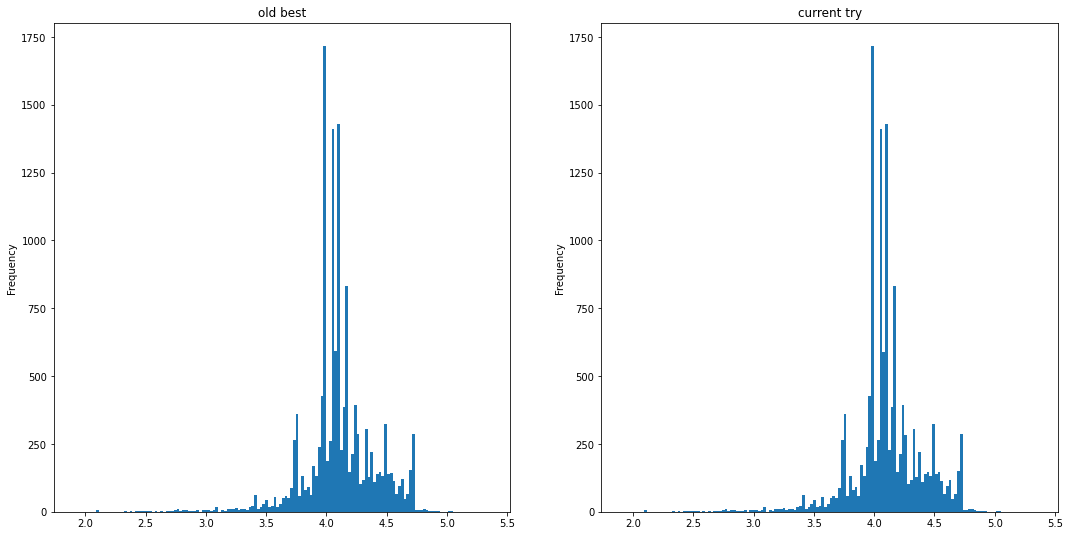

In [116]:
fig, axs = plt.subplots(1,2)
tes_pred2.plot.hist(bins=10, ax=axs[0], title='old best')
tes_pred.plot.hist(bins=150, ax=axs[1], title='current try')
plt.show()

# Model development log with LB score

**First 10 attempts are sort of finding the best combination between baseline models with ensemble weights**

Attemp 1 (1.04488):
- item, user, genre mean average 

Attemp 2 (1.04481):
- item, genre mean average 

Attemp 3 (1.042):
- item mean, user count regression, genre mean average 

Attemp 4 (1.04092):
- item mean, user count & n_following regression, genre mean average 

Attemp 5 (1.03976):
- item mean, user count & n_following regression average 

Attemp 6 (1.03922):
- item mean + user count & n_connect regression weighted ensemble 

Attemp 7 (1.03919):
- item mean + user count & n_following regression weighted ensemble 

**Attemp 8 (1.03335):**
- item mean fillna genre mean + user count & n_following regression weighted ensemble 

Attemp 9 (1.03479):
- item mean fillna genre mean + user mean
- then fillna mean_following regression
- then fillna user count & n_following regression weighted ensemble

**The later attempts are including partial testset predictions from MF models**

**Attemp 10 (1.03309):**
- item mean fillna genre mean ; user count & n_following regression weighted ensemble (60, 40) 
- avergae over partial MF (My old model) for old item and old user 

**Attemp 11 (1.03228):**
- item mean fillna genre mean ; user count & n_following regression weighted ensemble (60, 40) 
- avergae over partial MF (SVDpp) for old item and old user 

**Attemp 12 (1.03266):**
- item mean fillna genre mean ; user std regression ; user count & n_following regression weighted ensemble (60, 12, 40) 
- avergae over partial MF (SVDpp) for old item and old user 

### Attemp 13 (1.03104):
- item mean fillna genre mean ; user count & n_following regression weighted ensemble (65, 35) 
- average over full MF on train set (SVDpp)

**Attemp 14 (1.03152):**
- item mean fillna genre mean ; user count & n_following regression weighted ensemble (65, 35) 
- average over full MF on train set (SVDpp), fillna by neighbor predictions (allow default predictions if user or item is new) in social net

# BEST Attemp 15 (1.02915):
- item mean fillna genre mean ; user count & n_following regression weighted ensemble (65, 35) 
- average over full MF on train set (SVDpp), fillna by neighbor predictions (allow only old users and old items in the model) in social net